# Analysis of Belle2 MonteCarlo Data

__Authors:__

- Valeria Fioroni (University of Padova)
- Matteo Guida (University of Padova)
- Philipp Zehetner (University of Padova, Ludwig Maximilian University of Munich)
- [Stack Overflow](https://stackoverflow.com/)


In [1]:
import os, sys, pprint
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [85]:
Testing = True # Uses only a small subset of the data and trains on fewer epochs. 
Local_Philipp = True
VM = False

if Testing: print("For testing purpose only a small number of events are used")
if Local_Philipp : print("Paths are set to be run on Philipps Computer")
elif VM : print("Paths are set to run on the VM")

For testing purpose only a small number of events are used
Paths are set to be run on Philipps Computer


## Reading and Preparing Data

In [73]:
# Define branches that we need for our analysis
Masses = ['B0_M', 'B0_ErrM', 'B0_SigM', 'B0_K_S0_M', 'B0_K_S0_ErrM', 'B0_K_S0_SigM', 'B0_etap_M', 'B0_etap_ErrM', 
          'B0_etap_SigM', 'B0_etap_eta_M', 'B0_etap_eta_ErrM', 'B0_etap_eta_SigM']
Kinetics_CMS = ['B0_Pcms', 'B0_etap_Pcms', 'B0_etap_eta_Pcms', 'B0_etap_eta_gamma0_Pcms', 'B0_etap_eta_gamma1_Pcms',
                'B0_etap_pi0_Pcms', 'B0_etap_pi1_Pcms', 'B0_K_S0_Pcms']
Other_Kinetics = ['B0_deltae', 'B0_mbc']
DecayAngles = ['B0_decayAngle__bo0__bc', 'B0_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo0__bc',
               'B0_etap_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo2__bc']
Positions = ['B0_X', 'B0_ErrX', 'B0_Y', 'B0_ErrY', 'B0_Z', 'B0_ErrZ', 'B0_Rho',  
             'B0_etap_X', 'B0_etap_ErrX', 'B0_etap_Y', 'B0_etap_ErrY', 
             'B0_etap_Z', 'B0_etap_ErrZ', 'B0_etap_Rho',
             'B0_etap_eta_X', 'B0_etap_eta_ErrX', 'B0_etap_eta_Y',
             'B0_etap_eta_ErrY', 'B0_etap_eta_Z', 'B0_etap_eta_ErrZ', 'B0_etap_eta_Rho',
             'B0_etap_pi0_X', 'B0_etap_pi0_ErrX', 'B0_etap_pi0_Y', 'B0_etap_pi0_ErrY', 
             'B0_etap_pi0_Z', 'B0_etap_pi0_ErrZ', 'B0_etap_pi0_Rho', 
             'B0_etap_pi1_X', 'B0_etap_pi1_ErrX', 'B0_etap_pi1_Y', 'B0_etap_pi1_ErrY', 
             'B0_etap_pi1_Z', 'B0_etap_pi1_ErrZ', 'B0_etap_pi1_Rho', 
             'B0_K_S0_X', 'B0_K_S0_ErrX', 'B0_K_S0_Y', 'B0_K_S0_ErrY', 'B0_K_S0_Z',
             'B0_K_S0_ErrZ', 'B0_K_S0_Rho', 
             'B0_cosAngleBetweenMomentumAndVertexVector', 'B0_distance', 'B0_significanceOfDistance',
             'B0_dr', 'B0_etap_pi0_dr', 'B0_etap_pi1_dr', 'B0_K_S0_dr']
Vertex_Training = ['B0_VtxPvalue', 'B0_etap_VtxPvalue', 'B0_etap_eta_VtxPvalue', 'B0_etap_pi0_VtxPvalue',
                   'B0_etap_pi1_VtxPvalue', 'B0_K_S0_VtxPvalue', ]
Continuum_Suppression_Training = ['B0_TrCSMVA']

Training = Kinetics_CMS + Masses + Other_Kinetics + Continuum_Suppression_Training + Positions + DecayAngles + Vertex_Training
Important = Training + ['B0_isSignal' + 'evt_no']

In [4]:
from root_pandas import read_root

if Local_Philipp and not VM : 
    path = '/home/philipp/Desktop/Project/DATA/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Continuous/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Peaking/*.root'))
    
elif VM and not Local_Philipp : 
    print('Please set path for VM here')

Full_Signal = pd.concat((read_root(f, 'B0', columns=Important) for f in SFiles))
Full_Signal = Full_Signal[Full_Signal['B0_isSignal']==1].reset_index(drop=True)
Full_Continuous = pd.concat((read_root(f, 'B0', columns=Important) for f in CFiles))
Full_Peaking = pd.concat((read_root(f, 'B0', columns=Important) for f in PFiles))

Signal = Full_Signal[Training]
Continuous = Full_Continuous[Training]
Peaking = Full_Peaking[Training]

Welcome to JupyROOT 6.16/00


/home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.4 is currently installed but you installed root_numpy against numpy 1.9.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [5]:
Signal['Type'] = 2
Continuous['Type'] = 1
Peaking['Type'] = 0

## Preprocessing

In [6]:
from random import seed
from random import randint

n_seed=1234
seed(n_seed)

In [7]:
from sklearn.model_selection import train_test_split

Sum_BS = pd.concat([Signal, Continuous, Peaking]).sample(frac=1)
X = Sum_BS.drop('Type',axis=1)
Y = Sum_BS['Type']

# For Testing purposes it's convenient to work with a small subset
if Testing : 
    N_Events = 10000
    X = X[:N_Events]
    Y = Y[:N_Events]

# We split our dataset into 70% training, 15% testing and 15% validation 
X_Train, X_Rest, Y_Train, Y_Rest = train_test_split(X, Y, train_size=0.7,random_state=randint(10**6,10**9))
X_Test, X_Validation, Y_Test, Y_Validation = train_test_split(X_Rest, Y_Rest, train_size=0.5,random_state=randint(10**6,10**9))

In [8]:
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical

ss = StandardScaler()
X_Train = ss.fit_transform(X_Train)
X_Test = ss.transform(X_Test)
X_Validation = ss.transform(X_Validation)

Y_Train = to_categorical(Y_Train, num_classes=3) 
Y_Test = to_categorical(Y_Test, num_classes=3)
Y_Validation = to_categorical(Y_Validation, num_classes=3)

Using TensorFlow backend.


In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=len(Training))
pcTrain = pd.DataFrame(data = pca.fit_transform(X_Train))
pcTest = pd.DataFrame(data = pca.transform(X_Test))
pcValidation = pd.DataFrame(data = pca.transform(X_Validation))

T50, T90, T95, T99, = False, False, False, False
for i in range(len(pca.explained_variance_ratio_)) : 
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.5 and T50 ==False) : 
        print(str(i+1) + ' variables explain 50% of the variance')
        T50 = True
        n_50 = i + 1 
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.9 and T90 ==False) : 
        print(str(i+1) + ' variables explain 90% of the variance')
        T90 = True
        n_90 = i + 1
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.95 and T95 ==False) : 
        print(str(i+1) + ' variables explain 95% of the variance')
        T95 = True
        n_95 = i + 1
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.99 and T99 ==False) : 
        print(str(i+1) + ' variables explain 99% of the variance')
        T99 = True
        n_99 = i + 1
        
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

11 variables explain 50% of the variance
36 variables explain 90% of the variance
42 variables explain 95% of the variance
50 variables explain 99% of the variance


<Figure size 640x480 with 1 Axes>

In [10]:
# For input_dim chose n_50, n_90, n_95 or n_99 depending on how much explained variance we require
input_dim = n_99
pcTrain = pcTrain.iloc[:, 0:input_dim]
pcTest = pcTest.iloc[:, 0:input_dim]
pcValidation = pcValidation.iloc[:, 0:input_dim]

## Create the Neural Network 

In [58]:
optimizer = ['SGD', 'Adam']
epochs = [10, 30]
if Testing : epochs = [1, 2]
batch_size = [100, 1000]
architectures = [ [50, 50], [50, 100, 50], [50, 100, 100, 50] ] 
activation = ['relu', 'elu']

In [83]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasClassifier

def build_DNN(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(pcTrain.shape[1],)))
    model.add(Dense(layers[0], input_shape=(pcTrain.shape[1],), activation='relu'))
    for i in range(1,len(layers)):
        model.add(Dense(layers[i], activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

def print_results() :
    print("Layers: ", layers)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params): 
        print("%f (%f) with %r" % (mean, stdev, param))


In [84]:
from sklearn.model_selection import GridSearchCV

results = []
grids = []
for architecture in architectures : 
    layers = architecture
    print("Using architecture: ", layers)
    model = KerasClassifier(build_fn=build_DNN, batch_size=10000, epochs=2)
    param_grid = dict(epochs=epochs, batch_size=batch_size,
                      activation=activation, optimizer=optimizer)
    grid = GridSearchCV(estimator=model, param_grid=param_grid,
                        n_jobs=-1, pre_dispatch=8)
    grid_result = grid.fit(pcTrain, Y_Train)
    results.append(grid_result)
    grids.append(grid)
    print_results()

Using architecture:  [50, 50]
Epoch 1/1
2334/2334 [==============================] - 3s 1ms/step
Epoch 1/1
2333/2333 [==============================] - 3s 1ms/step
Epoch 1/1
2333/2333 [==============================] - 3s 1ms/step
Epoch 1/1
2334/2334 [==============================] - 3s 1ms/step
Epoch 1/1
2333/2333 [==============================] - 3s 1ms/step
Epoch 1/1
2333/2333 [==============================] - 3s 1ms/step
Epoch 1/2
4666/4666 [==============================] - 7s 2ms/step - loss: 0.1439 - acc: 0.7319
Epoch 2/2
2334/2334 [==============================] - 3s 1ms/step
Epoch 1/2
4667/4667 [==============================] - 7s 1ms/step - loss: 0.1721 - acc: 0.6529
Epoch 2/2
2333/2333 [==============================] - 3s 1ms/step
Epoch 1/2
4667/4667 [==============================] - 7s 1ms/step - loss: 0.1506 - acc: 0.6990
Epoch 2/2
2333/2333 [==============================] - 3s 1ms/step
Epoch 1/2
4666/4666 [==============================] - 7s 2ms/step - loss: 0.14

2333/2333 [==============================] - 3s 1ms/step
Epoch 1/2
4666/4666 [==============================] - 9s 2ms/step - loss: 0.3242 - acc: 0.2049
Epoch 2/2
2334/2334 [==============================] - 4s 2ms/step
Epoch 1/2
4667/4667 [==============================] - 9s 2ms/step - loss: 0.2936 - acc: 0.5217
Epoch 2/2
2333/2333 [==============================] - 4s 2ms/step
Epoch 1/2
4667/4667 [==============================] - 9s 2ms/step - loss: 0.2844 - acc: 0.2408
Epoch 2/2
2333/2333 [==============================] - 3s 1ms/step
Epoch 1/2
4666/4666 [==============================] - 9s 2ms/step - loss: 0.2331 - acc: 0.4218
Epoch 2/2
2334/2334 [==============================] - 4s 2ms/step
Epoch 1/2
4667/4667 [==============================] - 8s 2ms/step - loss: 0.2616 - acc: 0.2081
Epoch 2/2
2333/2333 [==============================] - 3s 1ms/step
Epoch 1/2
4667/4667 [==============================] - 8s 2ms/step - loss: 0.2768 - acc: 0.3613
Epoch 2/2
2333/2333 [===========

2333/2333 [==============================] - 4s 2ms/step
Epoch 1/1
2334/2334 [==============================] - 4s 2ms/step
Epoch 1/1
2333/2333 [==============================] - 5s 2ms/step
Epoch 1/1
2333/2333 [==============================] - 4s 2ms/step
Epoch 1/1
2334/2334 [==============================] - 4s 2ms/step
Epoch 1/1
2333/2333 [==============================] - 4s 2ms/step
Epoch 1/1
2333/2333 [==============================] - 5s 2ms/step
Epoch 1/2
4666/4666 [==============================] - 11s 2ms/step - loss: 0.1435 - acc: 0.6914
Epoch 2/2
2334/2334 [==============================] - 5s 2ms/step
Epoch 1/2
4667/4667 [==============================] - 11s 2ms/step - loss: 0.1500 - acc: 0.6906
Epoch 2/2
2333/2333 [==============================] - 4s 2ms/step
Epoch 1/2
4667/4667 [==============================] - 11s 2ms/step - loss: 0.1169 - acc: 0.7874
Epoch 2/2
2333/2333 [==============================] - 5s 2ms/step
Epoch 1/2
4666/4666 [============================

4667/4667 [==============================] - 12s 3ms/step - loss: 0.1218 - acc: 0.7694
Epoch 2/2
2333/2333 [==============================] - 5s 2ms/step
Epoch 1/2
4667/4667 [==============================] - 12s 3ms/step - loss: 0.1145 - acc: 0.7877
Epoch 2/2
2333/2333 [==============================] - 5s 2ms/step
Epoch 1/2
4666/4666 [==============================] - 12s 3ms/step - loss: 0.1232 - acc: 0.7505
Epoch 2/2
2334/2334 [==============================] - 5s 2ms/step
Epoch 1/2
4667/4667 [==============================] - 12s 3ms/step - loss: 0.1230 - acc: 0.7671
Epoch 2/2
2333/2333 [==============================] - 5s 2ms/step
Epoch 1/2
4667/4667 [==============================] - 12s 3ms/step - loss: 0.1189 - acc: 0.7422
Epoch 2/2
2333/2333 [==============================] - 5s 2ms/step
Epoch 1/1
2334/2334 [==============================] - 5s 2ms/step
Epoch 1/1
2333/2333 [==============================] - 5s 2ms/step
Epoch 1/1
2333/2333 [==============================] - 5

2333/2333 [==============================] - 5s 2ms/step
Epoch 1/2
4667/4667 [==============================] - 13s 3ms/step - loss: 0.2327 - acc: 0.4686
Epoch 2/2
2333/2333 [==============================] - 5s 2ms/step
Epoch 1/2
7000/7000 [==============================] - 14s 2ms/step - loss: 0.0991 - acc: 0.7981
Epoch 2/2
7000/7000 [==============================] - 1s 155us/step - loss: 0.0413 - acc: 0.9187
Layers:  [50, 100, 100, 50]
Best: 0.963000 using {'activation': 'elu', 'batch_size': 100, 'epochs': 2, 'optimizer': 'Adam'}
0.944857 (0.007988) with {'activation': 'relu', 'batch_size': 100, 'epochs': 1, 'optimizer': 'SGD'}
0.949143 (0.007808) with {'activation': 'relu', 'batch_size': 100, 'epochs': 1, 'optimizer': 'Adam'}
0.960571 (0.002443) with {'activation': 'relu', 'batch_size': 100, 'epochs': 2, 'optimizer': 'SGD'}
0.959571 (0.002527) with {'activation': 'relu', 'batch_size': 100, 'epochs': 2, 'optimizer': 'Adam'}
0.611000 (0.073739) with {'activation': 'relu', 'batch_siz

In [86]:
scores = []
params = []
for result in results : 
    scores.append(result.best_score_)
    params.append(result.best_params_)
    pprint.pprint(result.best_score_)
    pprint.pprint(result.best_params_)

0.9598571525045804
{'activation': 'elu', 'batch_size': 100, 'epochs': 2, 'optimizer': 'Adam'}
0.965142862881933
{'activation': 'relu', 'batch_size': 100, 'epochs': 2, 'optimizer': 'SGD'}
0.9630000015497208
{'activation': 'elu', 'batch_size': 100, 'epochs': 2, 'optimizer': 'Adam'}


### Evaluate the best Network

In [87]:
Best_Score = max(scores) # Best Score: 
Best_Params = params[scores.index(Best_Score)]
Best_Arch = architectures[scores.index(Best_Score)]

layers = Best_Arch
Best_Model = build_DNN(optimizer = Best_Params['optimizer'],
                       activation = Best_Params['activation'])
Best_Model.fit(pcTrain, Y_Train, batch_size = Best_Params['batch_size'],
               epochs = 5*Best_Params['epochs'])

Epoch 1/10
7000/7000 [==============================] - 14s 2ms/step - loss: 0.1096 - acc: 0.7767
Epoch 2/10
7000/7000 [==============================] - 1s 154us/step - loss: 0.0410 - acc: 0.9213
Epoch 3/10
7000/7000 [==============================] - 1s 150us/step - loss: 0.0362 - acc: 0.9290
Epoch 4/10
7000/7000 [==============================] - 1s 150us/step - loss: 0.0316 - acc: 0.9386
Epoch 5/10
7000/7000 [==============================] - 1s 152us/step - loss: 0.0291 - acc: 0.9423
Epoch 6/10
7000/7000 [==============================] - 1s 151us/step - loss: 0.0308 - acc: 0.9374
Epoch 7/10
7000/7000 [==============================] - 1s 152us/step - loss: 0.0271 - acc: 0.9456
Epoch 8/10
7000/7000 [==============================] - 1s 161us/step - loss: 0.0257 - acc: 0.9493
Epoch 9/10
7000/7000 [==============================] - 1s 162us/step - loss: 0.0242 - acc: 0.9531
Epoch 10/10
7000/7000 [==============================] - 1s 165us/step - loss: 0.0226 - acc: 0.9561


In [88]:
y_score = Best_Model.predict(pcValidation)
y_score
Y_Validation

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

[0. 0. 1. ... 0. 0. 1.]


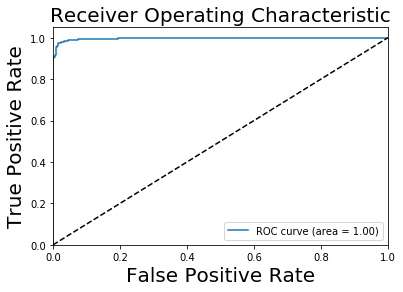

In [89]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(Y_Validation[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_Validation.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print(Y_Validation.ravel())
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('Receiver Operating Characteristic',fontsize=20)
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

In [90]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=15)

    plt.ylabel('TRUE LABEL',fontsize=20)
    plt.xlabel('PREDICTED LABEL',fontsize=20)
    #fig.set_size_inches(14, 10)
    plt.tight_layout()

In [91]:
from sklearn.metrics import confusion_matrix

Y_train_predict = Best_Model.predict_proba(pcTrain)
Y_test_predict = Best_Model.predict_proba(pcTest)
Y_test_single_col = np.where(Y_Test==1)[1]
Y_test_mo = pd.get_dummies(Y_test_single_col[:])
Y_test_predict_mo = Y_test_predict.round()
cnf_matrix = confusion_matrix(Y_test_mo.values.argmax(axis=1), Y_test_predict_mo.argmax(axis=1))

Normalized confusion matrix
[[0.         0.5        0.5       ]
 [0.00380711 0.97588832 0.02030457]
 [0.00142045 0.02272727 0.97585227]]


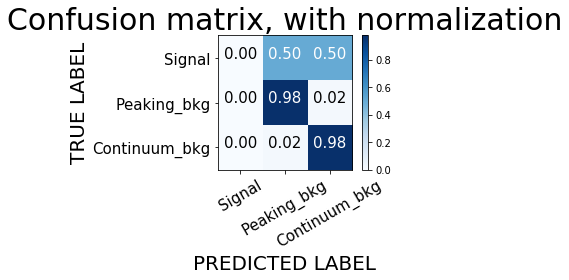

In [92]:
import itertools

plot_confusion_matrix(cnf_matrix, classes=['Signal', 'Peaking_bkg', 'Continuum_bkg'],
                       title='Confusion matrix, with normalization')

### Store the Weights

In [66]:
# !!! DO STUFF!!!

## XGBOOST

In [76]:
%%time
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import warnings

Y_train_single_col=np.where(Y_Train==1)[1]
Y_test_single_col=np.where(Y_Test==1)[1]

warnings.filterwarnings(action='ignore', category=DeprecationWarning)

print("Training on %i examples with %i features"%pcTrain.shape)

#Use default parameters and train on full dataset
XGBclassifier = xgb.sklearn.XGBClassifier(nthread=-1, seed=1, n_estimators=1000, n_jobs = 1,
                                        objective = 'multi:softmax',silent=1,tree_method='approx')
#Train and time classifier
XGBclassifier.fit(pcTrain, Y_train_single_col)

#Make Predictions
print("Predicting on %i examples with %i features\n"%X_Test.shape)
y_pred= XGBclassifier.predict(pcTest)

#Print Results
print("Model Accuracy with all features: {:.2f}%".format(100*XGBclassifier.score(X_Test, Y_test_single_col)))



Training on 7000 examples with 50 features
Predicting on 1500 examples with 83 features



ValueError: feature_names mismatch: ['0 ', '1 ', '2 ', '3 ', '4 ', '5 ', '6 ', '7 ', '8 ', '9 ', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82']
expected 9 , 48, 40, 2 , 32, 42, 44, 3 , 6 , 23, 13, 8 , 20, 21, 36, 38, 34, 17, 1 , 49, 7 , 47, 28, 31, 24, 46, 0 , 30, 43, 41, 18, 19, 25, 22, 10, 35, 27, 4 , 11, 45, 29, 33, 16, 37, 39, 14, 26, 12, 5 , 15 in input data
training data did not have the following fields: f75, f78, f13, f72, f77, f56, f45, f21, f25, f22, f42, f52, f47, f3, f14, f23, f76, f5, f1, f73, f32, f34, f20, f2, f63, f59, f70, f61, f41, f30, f36, f12, f8, f27, f39, f48, f29, f17, f66, f0, f18, f68, f10, f33, f79, f31, f58, f53, f9, f28, f82, f64, f50, f16, f74, f6, f4, f46, f26, f44, f62, f43, f80, f35, f40, f51, f24, f7, f19, f71, f60, f11, f38, f15, f67, f57, f49, f81, f55, f37, f69, f54, f65